## Object Detection 실습(yolov5)

210722

YOLOv5 : https://github.com/ultralytics/yolov5
        
- 설치(torch는 1.12 version)
> 1. git clone https://github.com/ultralytics/yolov5.git
> 2. cd yolov5
> 3. pip install -r requirements.txt

- YOLOv5x 모델 선정
- 입력이미지 640으로 작고, 그 중에 가장 성능이 좋으면서 추론시간 6ms 가능, 88M개의 파라미터 사용
- [참고](https://dacon.io/competitions/official/235855/codeshare/3743?fbclid=IwAR1ucZ3KBc74hNYC04Lp8omR6wnJ5mwjnQJhFmJh0Pn78x3nTJ-LBmDdPYI)

In [1]:
!git clone https://github.com/airobotlab/lecture_5_yolov5.git
!mv lecture_5_yolov5/* .
!rm -rf lecture_5_yolov5
!unzip mydata.zip -d ./mydata
!pip install -qr requirements.txt  # install dependencies

Cloning into 'lecture_5_yolov5'...
remote: Enumerating objects: 13322, done.
remote: Counting objects: 100% (33/33), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 13322 (delta 16), reused 2 (delta 0), pack-reused 13289
Receiving objects: 100% (13322/13322), 36.87 MiB | 27.92 MiB/s, done.
Resolving deltas: 100% (9186/9186), done.
Archive:  mydata.zip
images/small/국어_2017학년도_11월_30번.jpg:  mismatching "local" filename (images/small/ъ╡ньЦ┤_2017эХЩыЕДыПД_11ьЫФ_30ы▓И.jpg),
         continuing with "central" filename version
  inflating: ./mydata/images/small/국어_2017학년도_11월_30번.jpg  
images/small/국어_2017학년도_11월_32번.jpg:  mismatching "local" filename (images/small/ъ╡ньЦ┤_2017эХЩыЕДыПД_11ьЫФ_32ы▓И.jpg),
         continuing with "central" filename version
  inflating: ./mydata/images/small/국어_2017학년도_11월_32번.jpg  
images/small/국어_2018학년도_11월_24번.jpg:  mismatching "local" filename (images/small/ъ╡ньЦ┤_2018эХЩыЕДыПД_11ьЫФ_24ы▓И.jpg),
         continuing with "central" filena

# Setup

Clone repo, install dependencies and check PyTorch and GPU.

In [2]:
import torch
from IPython.display import Image, clear_output  # to display images

clear_output()
print(f"Setup complete. Using torch {torch.__version__} ({torch.cuda.get_device_properties(0).name if torch.cuda.is_available() else 'CPU'})")

Setup complete. Using torch 1.12.0+cu113 (Tesla P100-PCIE-16GB)


# 1. Inference

`detect.py` runs YOLOv5 inference on a variety of sources, downloading models automatically from the [latest YOLOv5 release](https://github.com/ultralytics/yolov5/releases), and saving results to `runs/detect`. Example inference sources are:

<img src="https://user-images.githubusercontent.com/26833433/114307955-5c7e4e80-9ae2-11eb-9f50-a90e39bee53f.png" width="900"> 

In [3]:
!nvidia-smi

Fri Jul 22 09:16:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   45C    P0    28W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [4]:
%%time
!python detect.py --weights yolov5x.pt --img 640 --conf 0.25 --source data/images/ --device 0

detect: weights=['yolov5x.pt'], source=data/images/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 2022-7-22 torch 1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

100% 166M/166M [00:14<00:00, 12.2MB/s]

Fusing layers... 
YOLOv5x summary: 444 layers, 86705005 parameters, 0 gradients
image 1/2 /content/data/images/bus.jpg: 640x480 4 persons, 1 bus, Done. (0.029s)
image 2/2 /content/data/images/zidane.jpg: 384x640 3 persons, 2 ties, Done. (0.028s)
Speed: 0.4ms pre-process, 28.7ms inference, 25.9ms NMS per image at shape (1, 3, 640, 640)
Results saved to runs/detect/exp
CPU times: user 349 ms, sys: 76.5 ms, total: 426 ms
Wall time: 33.2 s


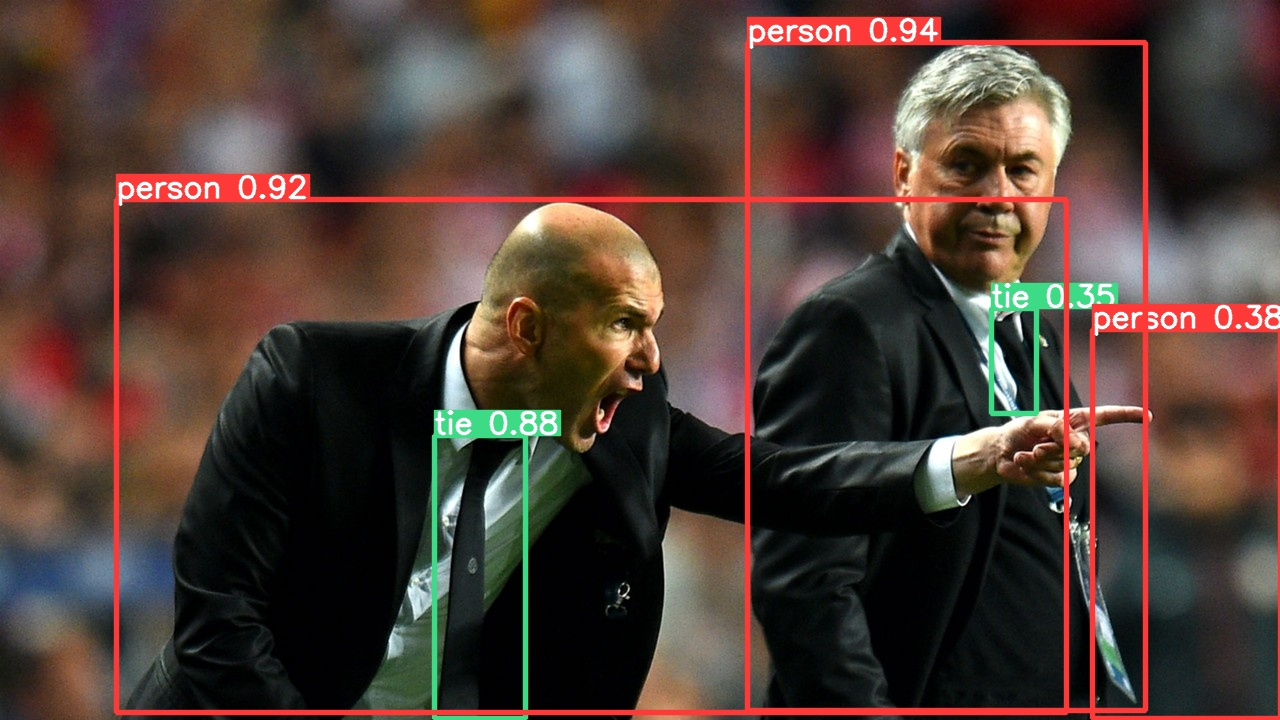

In [5]:
Image(filename='runs/detect/exp/zidane.jpg', width=600)

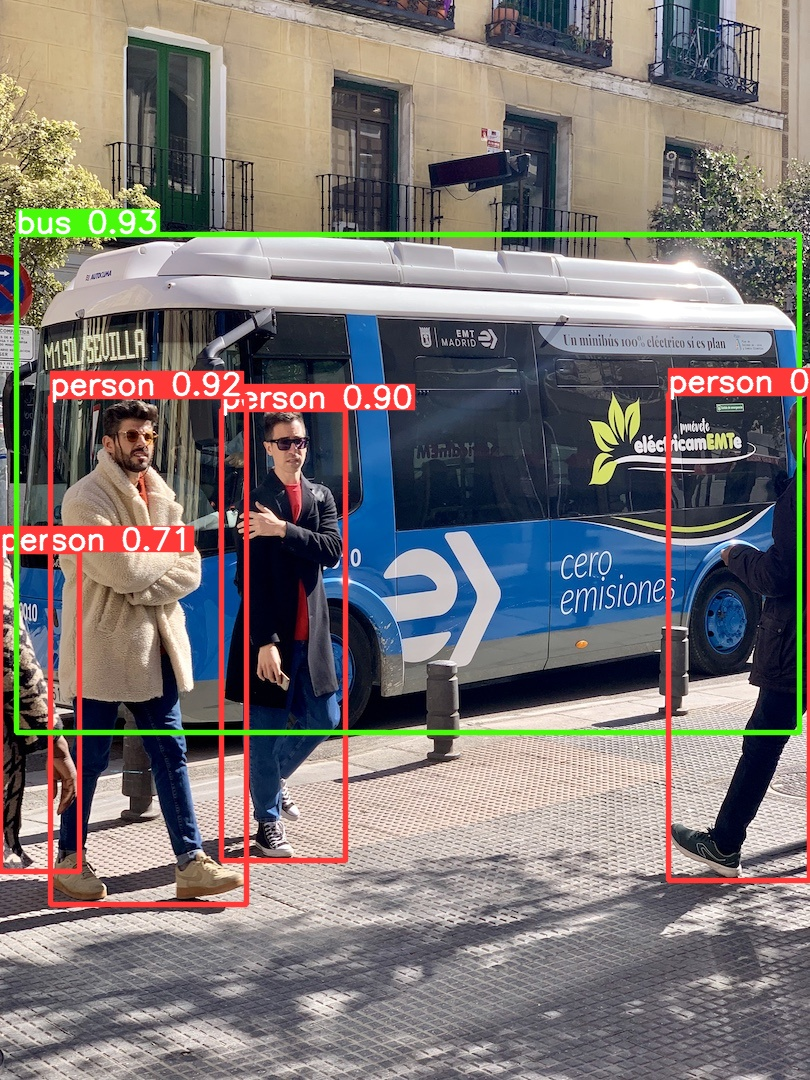

In [6]:
Image(filename='runs/detect/exp/bus.jpg', width=600)

# 3. OD Train!

210813

# DATA 준비

- mydata 폴더 안에 images, labels 폴더를 준비하자
- 두 폴더 안에는 각각 train/validation/test 폴더를 준비한다
- 아래 yaml 파일에 train에 사용할 폴더를, validation에 사용할 폴더의 경로를 지정한다.
- nc는 물체검출을 위한 클래스의 개수
- names는 각 클래스의 이름


In [7]:
# 데이터 경로와 class 지정, 중요!!
import yaml

data_yaml = dict(
    train = './mydata/images/test/',
    val = './mydata/images/small/',
    nc = 3,
    names = ['question', 'hint', 'answer']
)

# Note that I am creating the file in the yolov5/data/ directory.
with open('data/mydata.yaml', 'w') as outfile:
    yaml.dump(data_yaml, outfile, default_flow_style=True)

In [8]:
## 50epochs, 32min
# 87.7M params, 175MB weight, 640x640
# https://wandb.ai/keepsteady/YOLOv5/runs/1cturje7
!python train.py --img 640 --batch 8 \
                --epochs 50 \
                --data mydata.yaml \
                --weights yolov5x.pt \
                --cache  # --nosave 

train: weights=yolov5x.pt, cfg=, data=mydata.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=8, imgsz=640, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=ram, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: skipping check (not a git repository), for updates see https://github.com/ultralytics/yolov5
YOLOv5 🚀 2022-7-22 torch 1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.015, hsv_s

# 4. Test

In [9]:
%%time
!python detect.py --weights runs/train/exp/weights/best.pt \
                  --source mydata/images/small/ \
                  --img 640 \
                  --conf 0.25 \
                  --device 0

detect: weights=['runs/train/exp/weights/best.pt'], source=mydata/images/small/, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.25, iou_thres=0.45, max_det=1000, device=0, view_img=False, save_txt=False, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 2022-7-22 torch 1.12.0+cu113 CUDA:0 (Tesla P100-PCIE-16GB, 16281MiB)

Fusing layers... 
Model summary: 444 layers, 86186872 parameters, 0 gradients, 203.8 GFLOPs
image 1/100 /content/mydata/images/small/국어_2017학년도_11월_30번.jpg: 640x640 1 question, 1 hint, 1 answer, Done. (0.033s)
image 2/100 /content/mydata/images/small/국어_2017학년도_11월_32번.jpg: 640x640 1 question, 1 answer, Done. (0.034s)
image 3/100 /content/mydata/images/small/국어_2018학년도_11월_24번.jpg: 640x640 1 question, 1 hint, 1 answer, Done. (0.034s)
image 4/100 /content

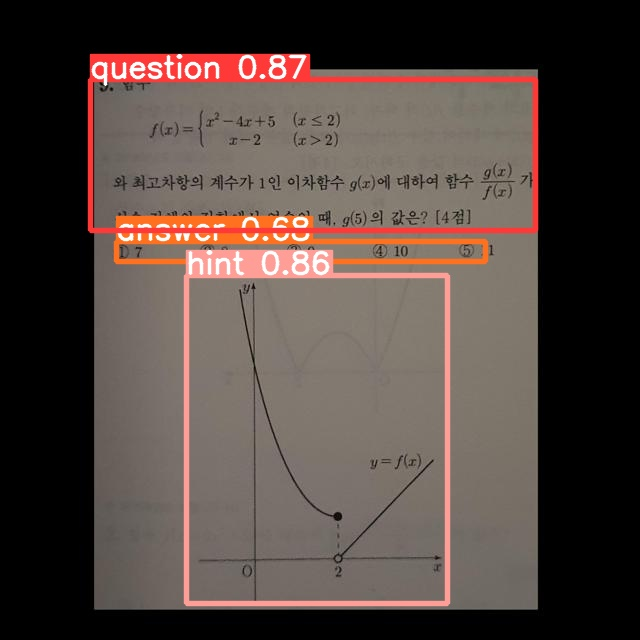

In [10]:
Image(filename='runs/detect/exp2/수학2_1_극한과 연속_9번.jpg', width=600)

## Local Logging

All results are logged by default to `runs/train`, with a new experiment directory created for each new training as `runs/train/exp2`, `runs/train/exp3`, etc. View train and test jpgs to see mosaics, labels, predictions and augmentation effects. Note a **Mosaic Dataloader** is used for training (shown below), a new concept developed by Ultralytics and first featured in [YOLOv4](https://arxiv.org/abs/2004.10934).

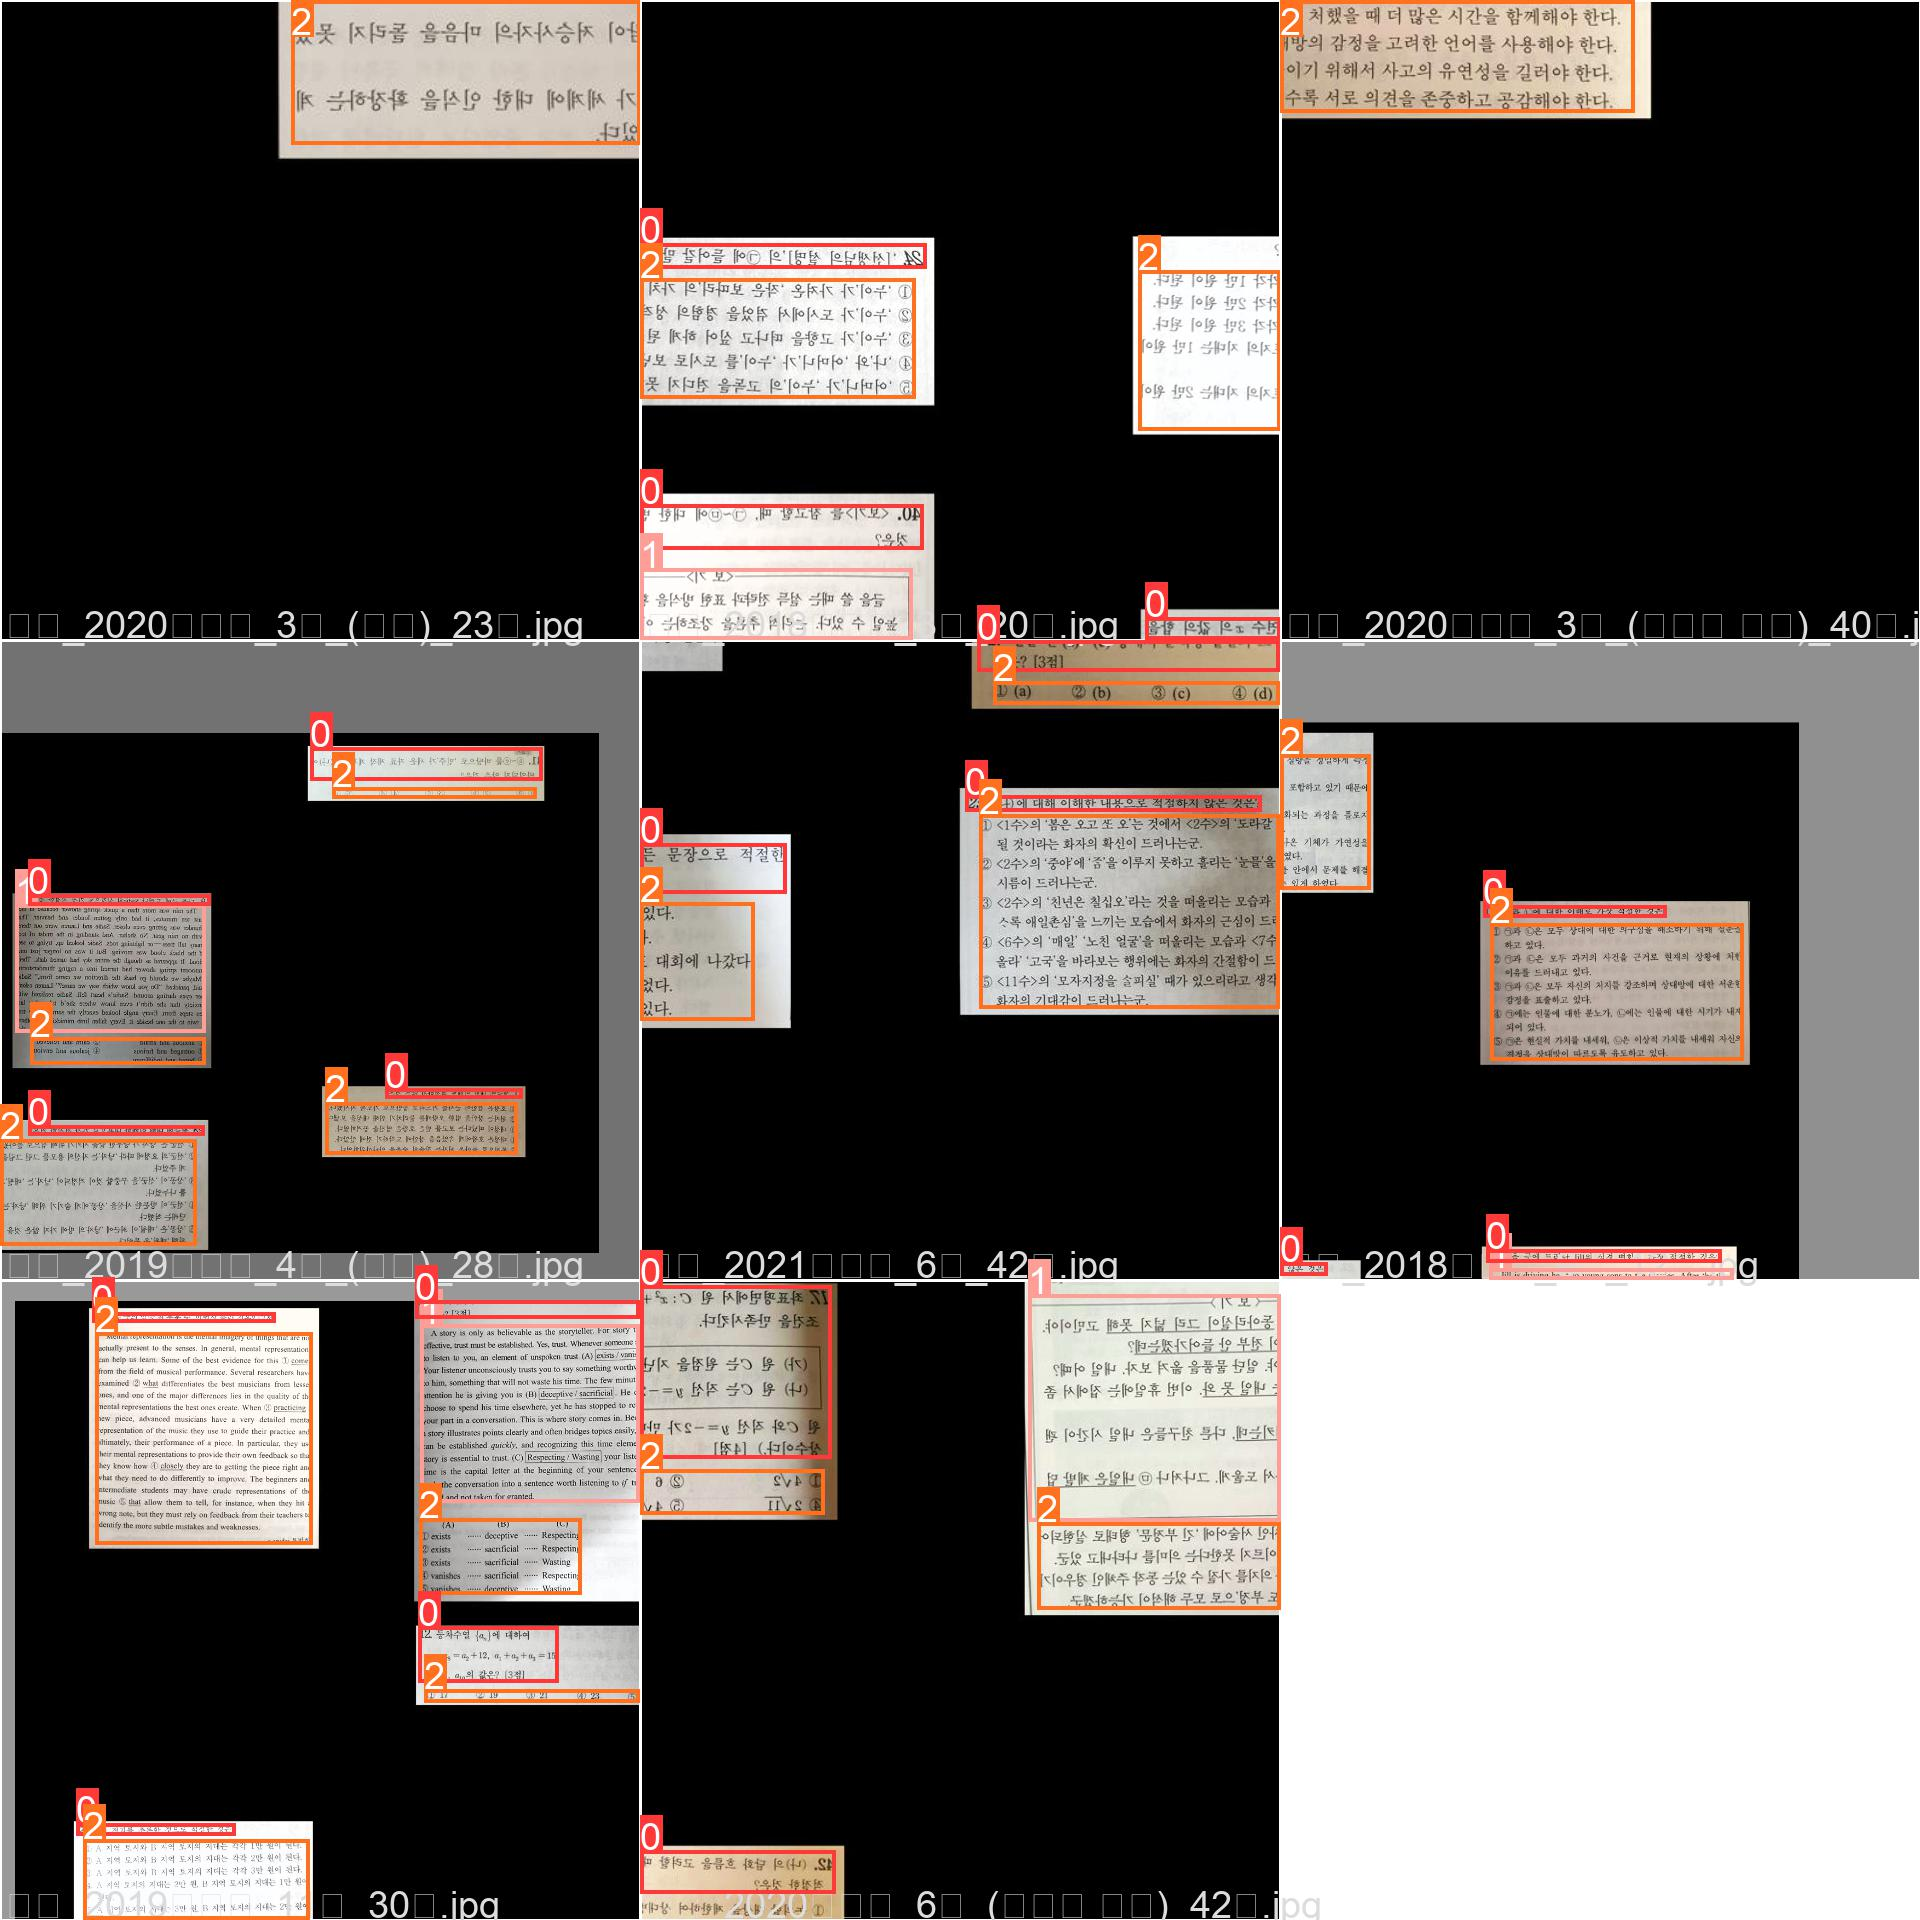

In [11]:
Image(filename='runs/train/exp/train_batch0.jpg', width=800)  # train batch 0 mosaics and labels

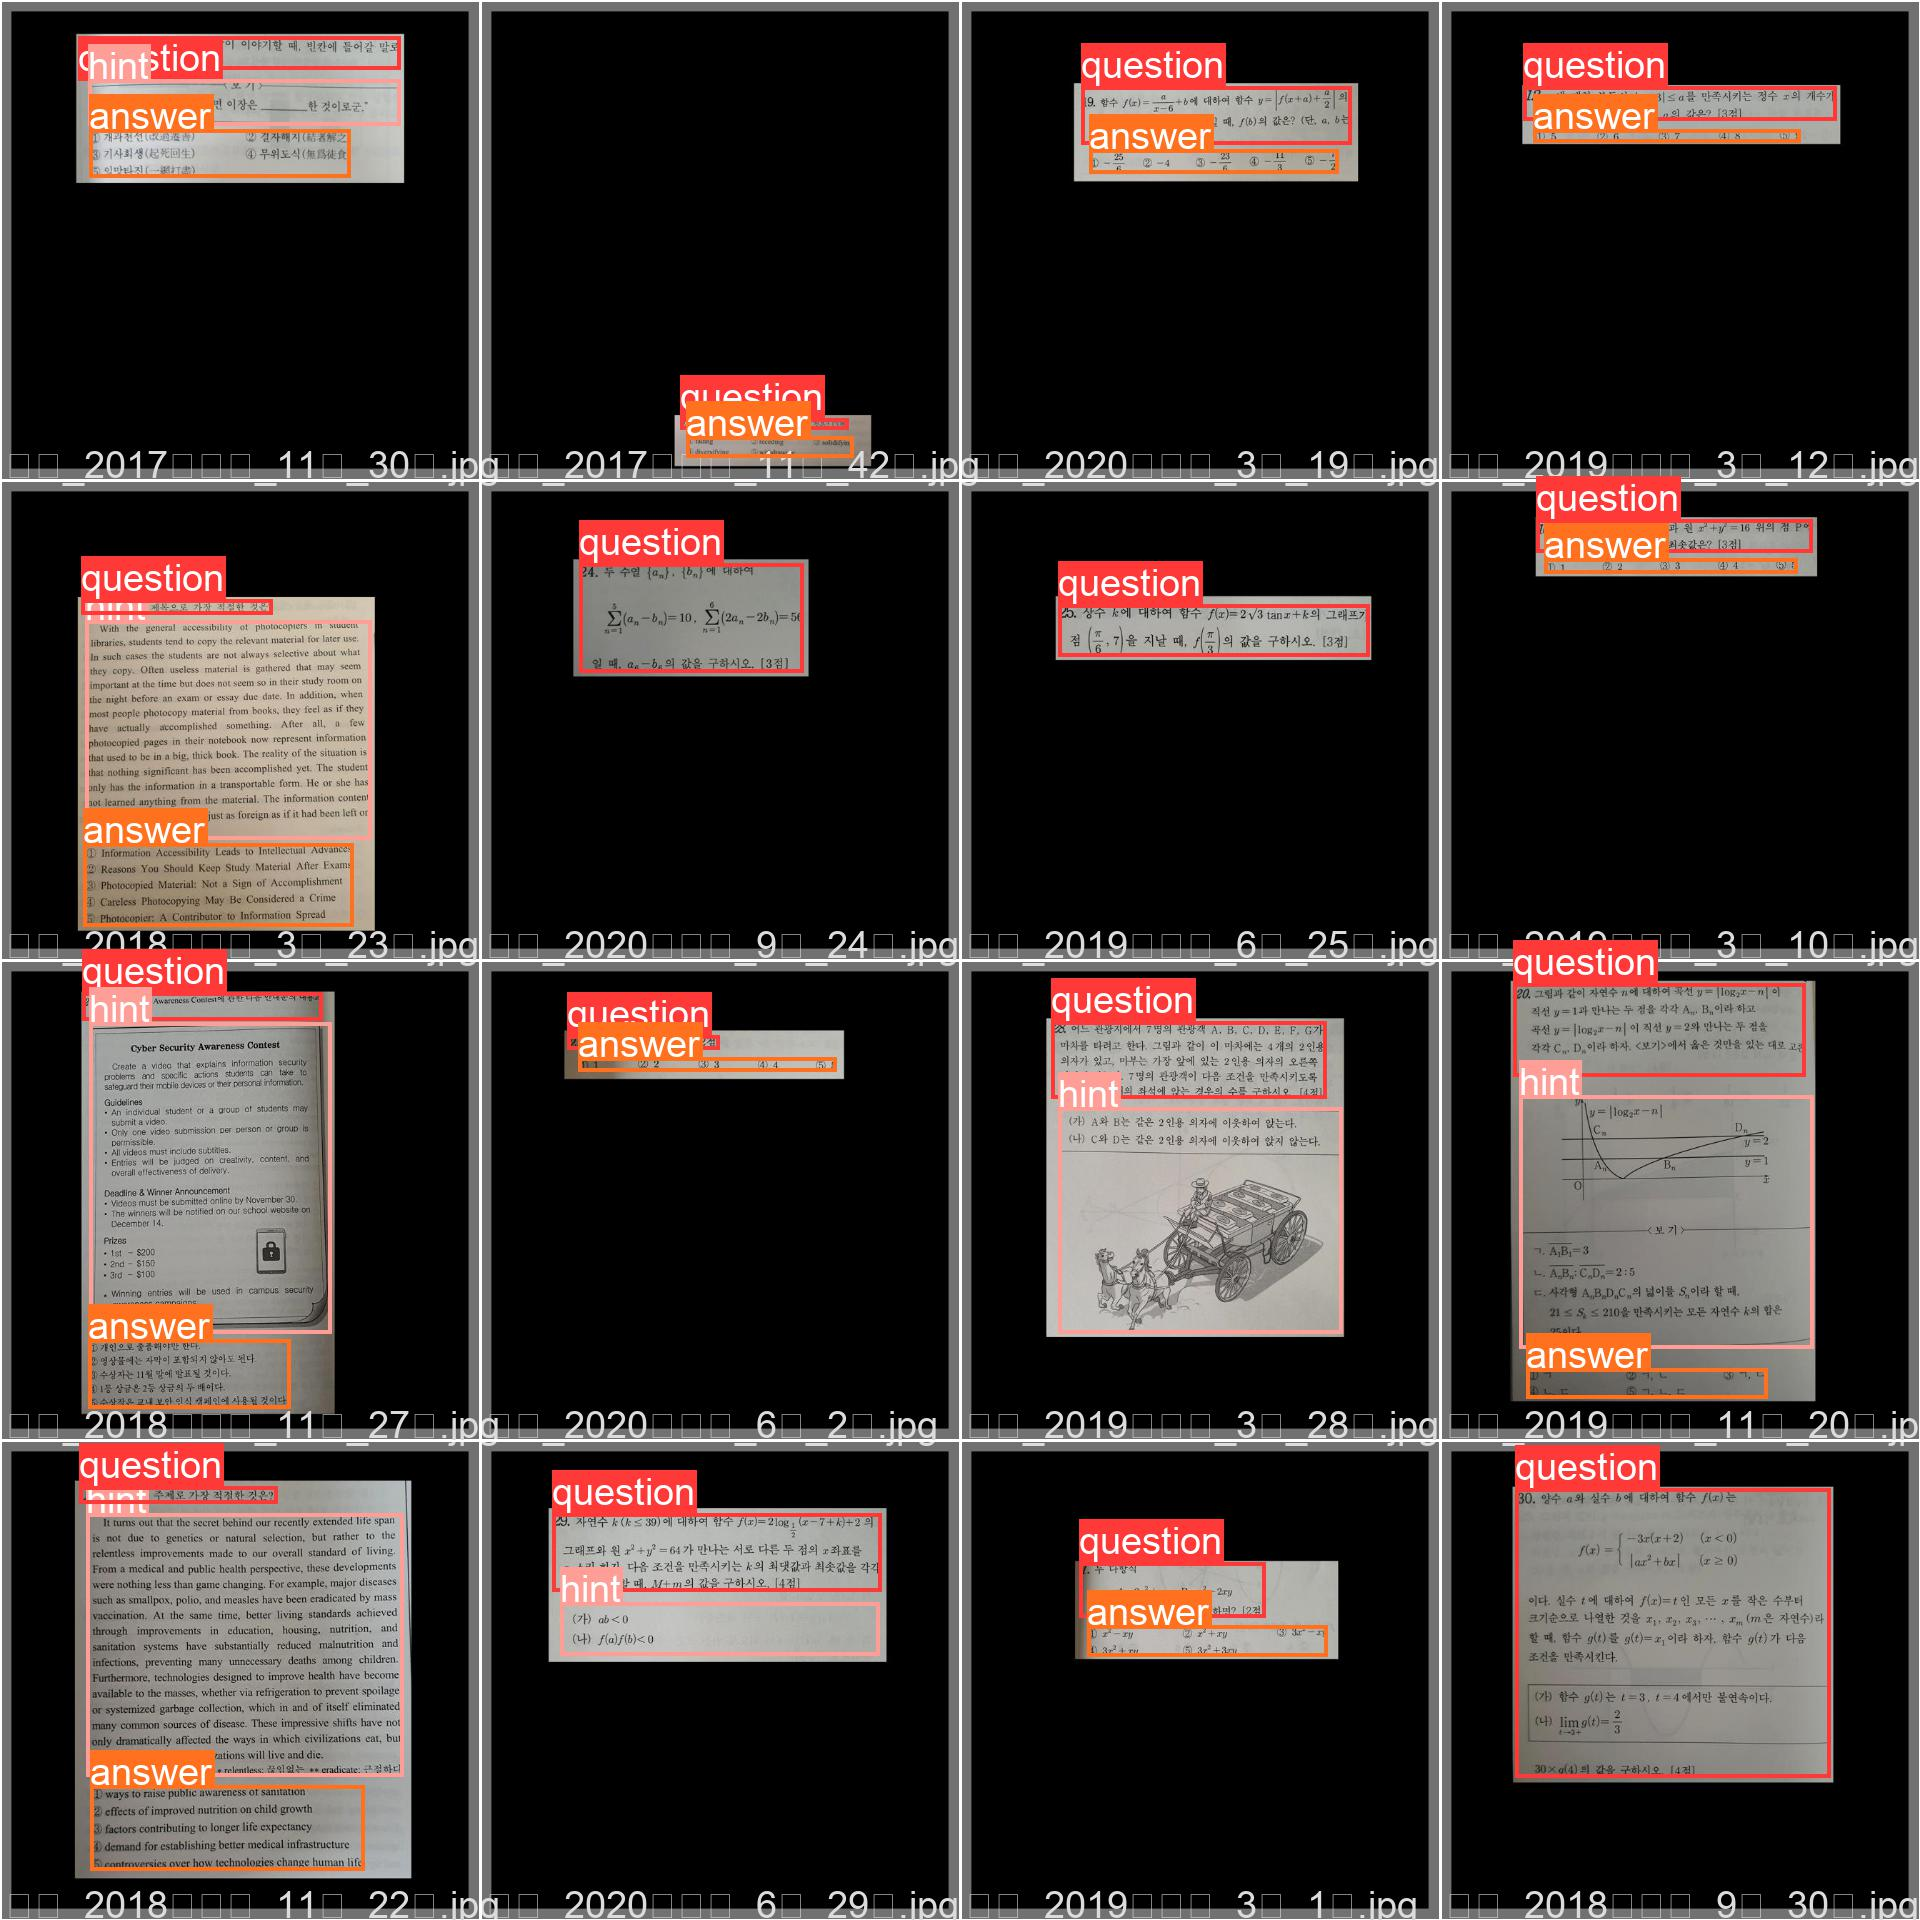

In [12]:
Image(filename='runs/train/exp/val_batch0_labels.jpg', width=800)  # test batch 0 labels

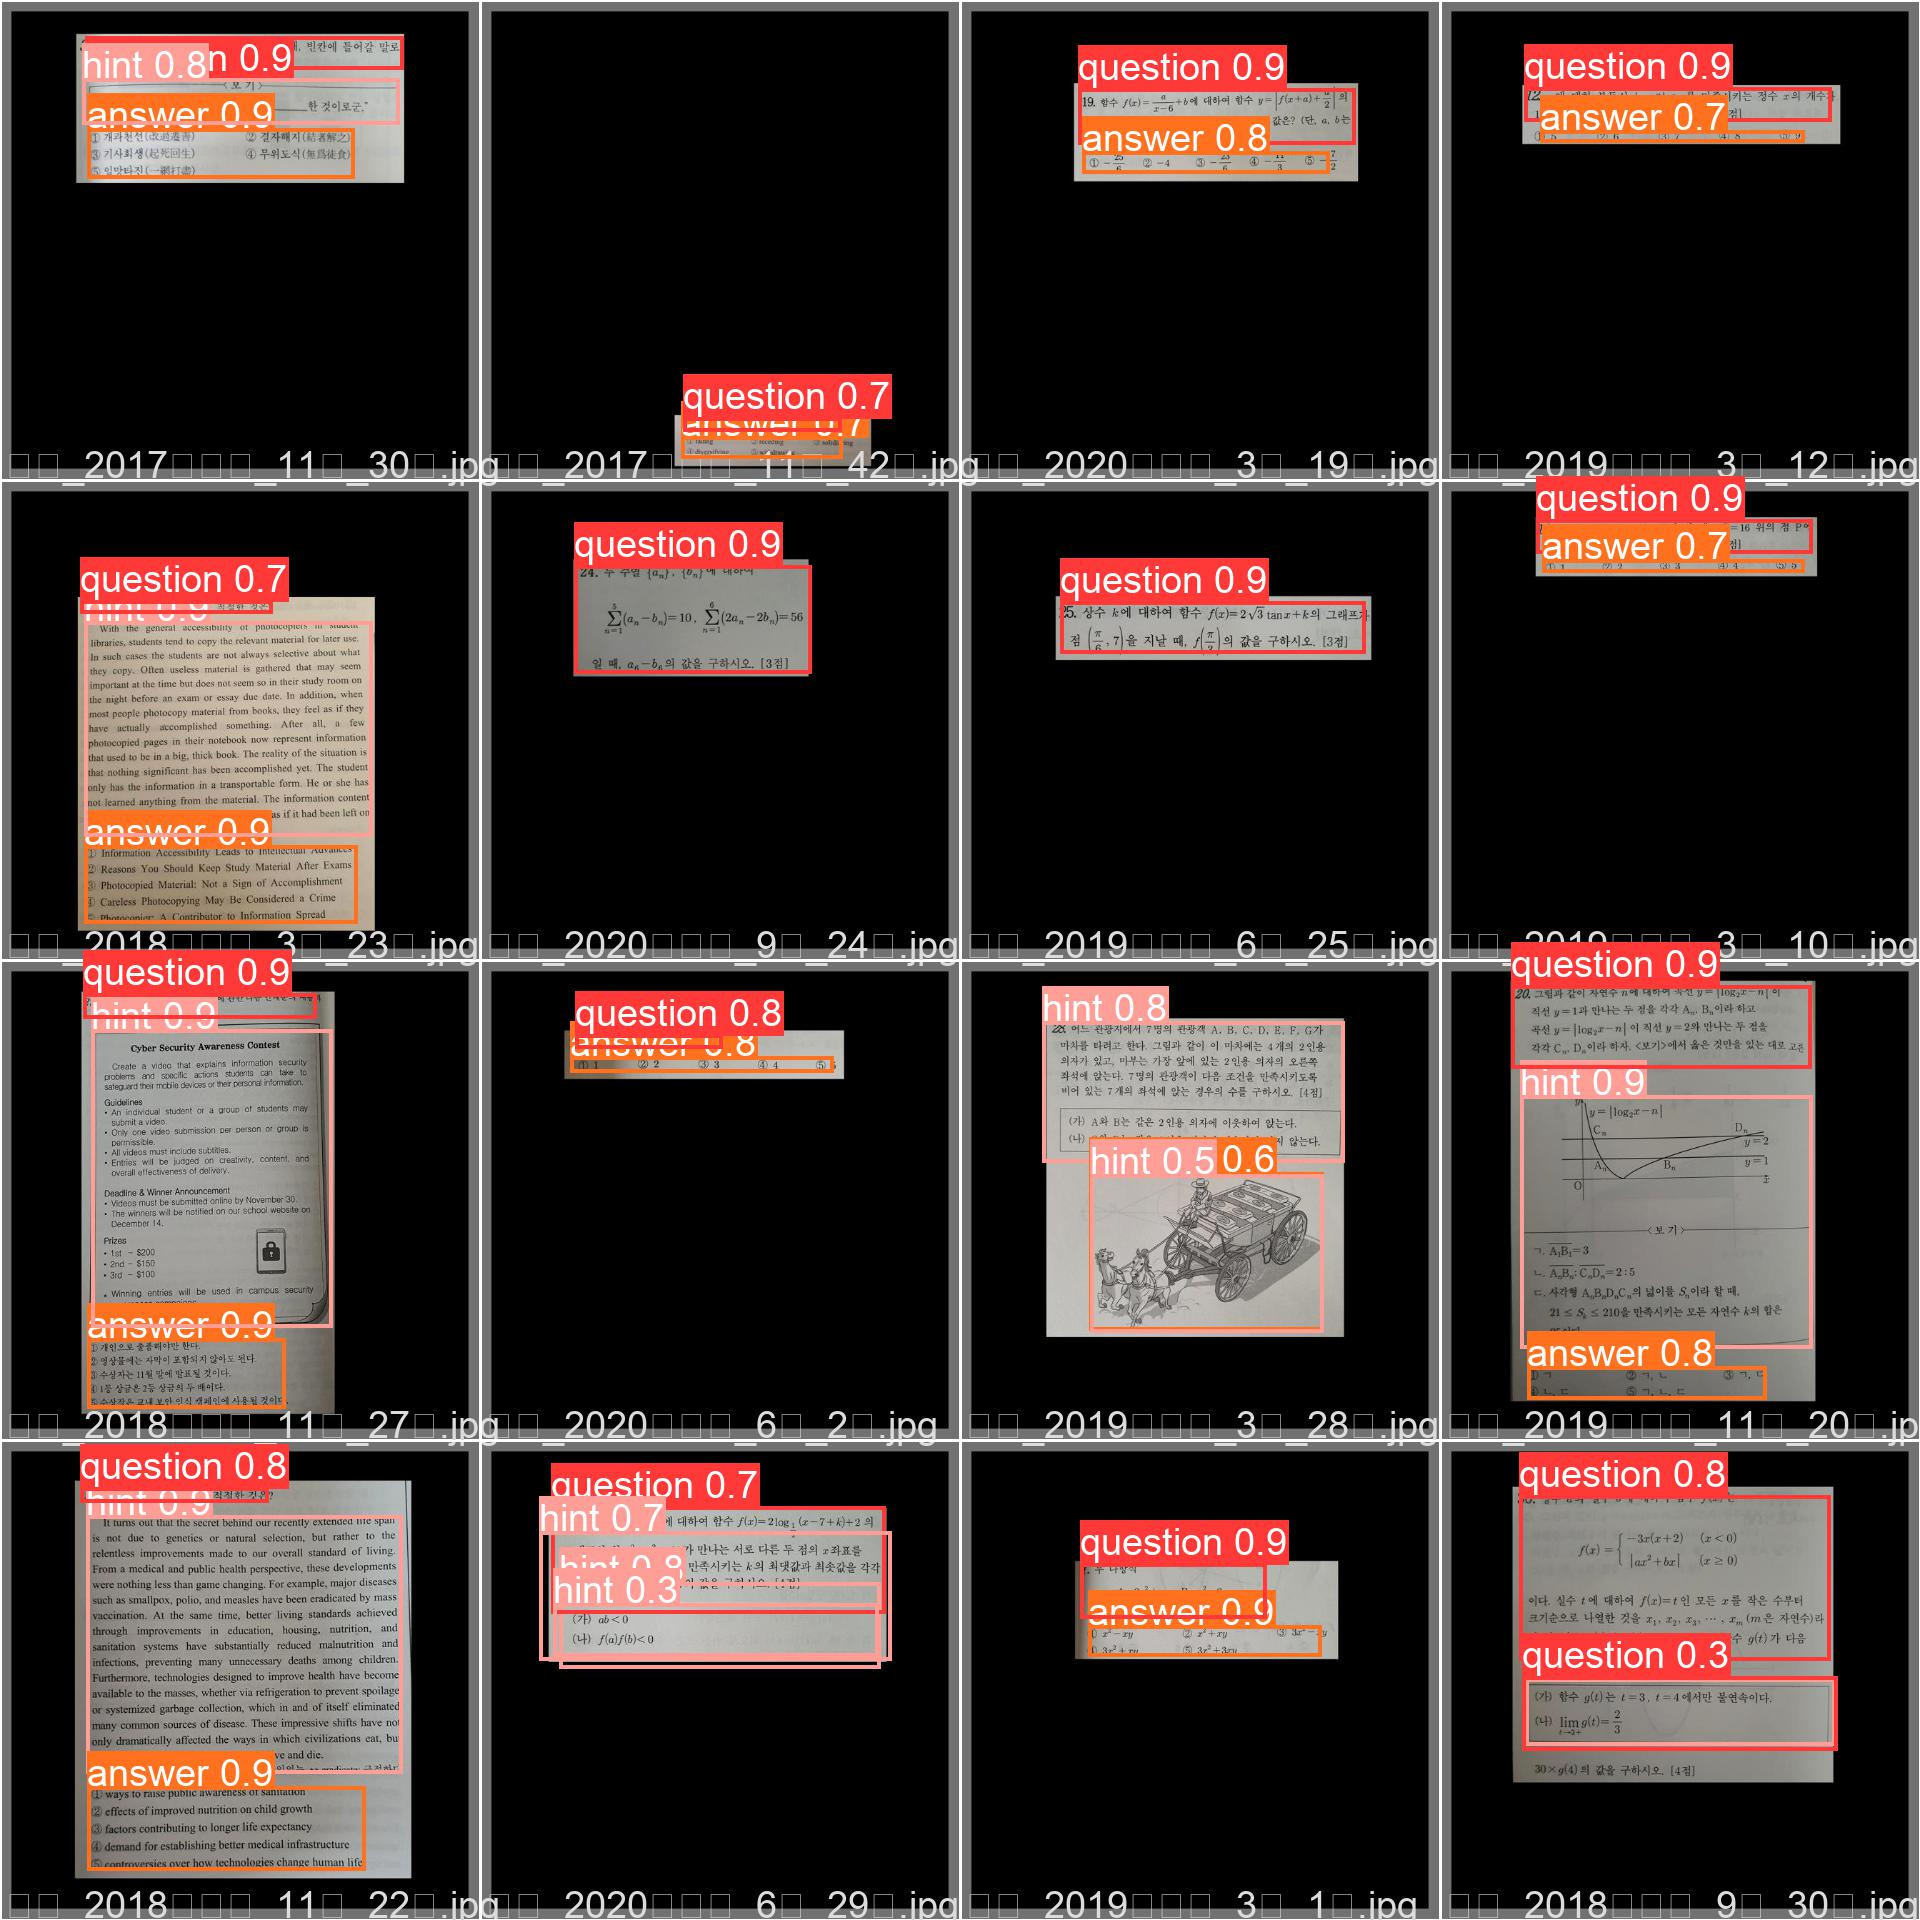

In [13]:
Image(filename='runs/train/exp/val_batch0_pred.jpg', width=800)  # test batch 0 predictions

Training losses and performance metrics are also logged to [Tensorboard](https://www.tensorflow.org/tensorboard) and a custom `results.txt` logfile which is plotted as `results.png` (below) after training completes. Here we show YOLOv5s trained on COCO128 to 300 epochs, starting from scratch (blue), and from pretrained `--weights yolov5s.pt` (orange).

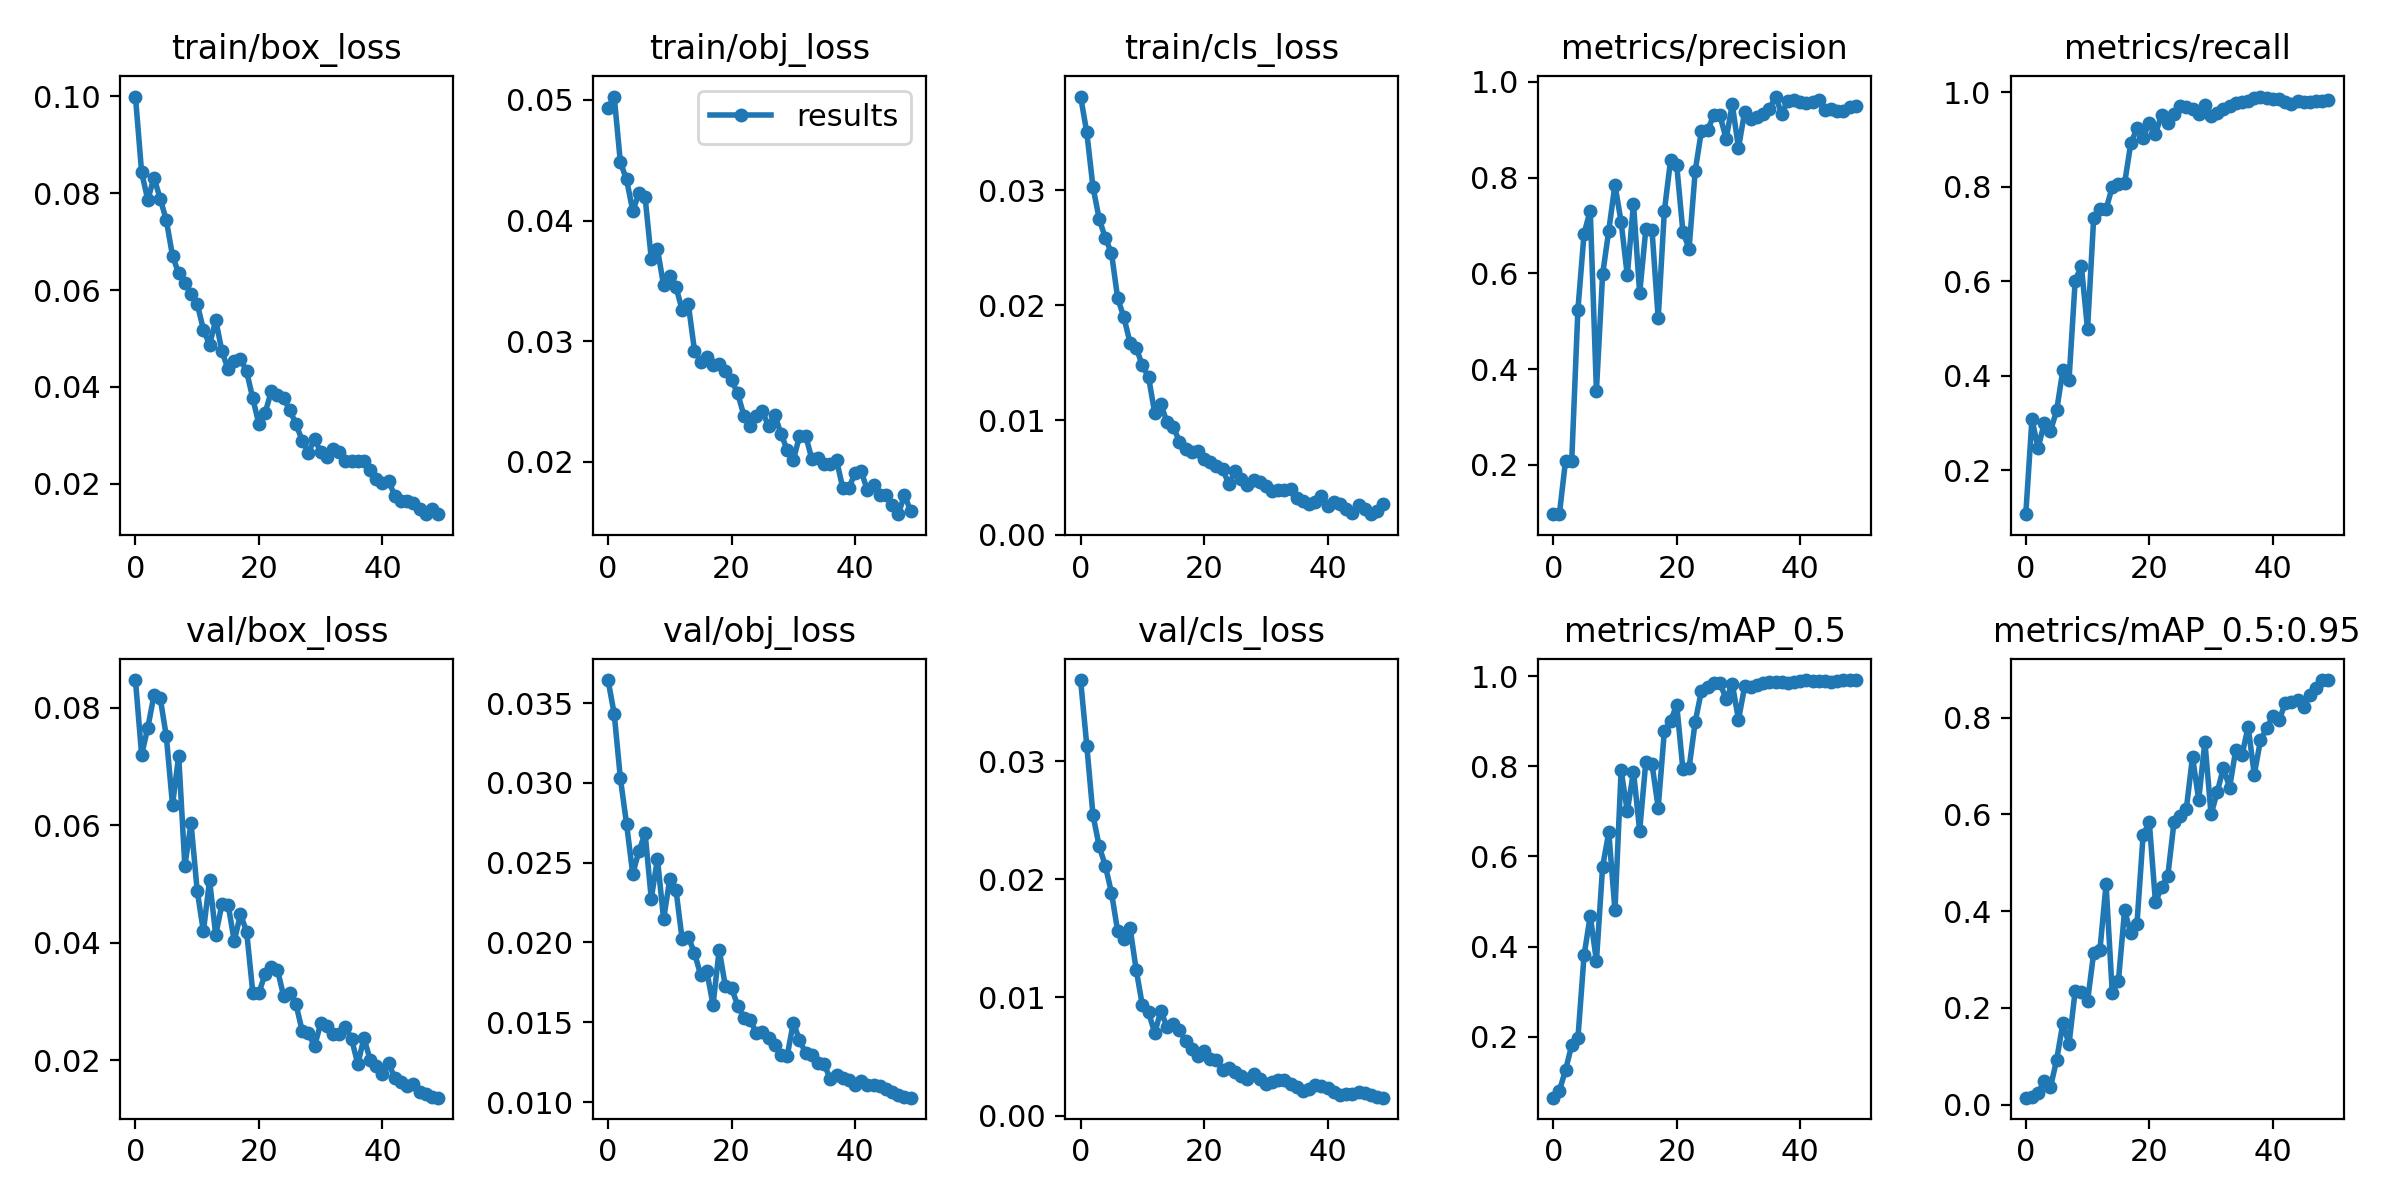

In [14]:
from utils.plots import plot_results 
plot_results('runs/train/exp/results.csv')  # plot all results*.txt as results.png
Image(filename='runs/train/exp/results.png', width=800)

In [15]:
## parameter 선언
class Myconfig():
    def __init__(self):
        self.weights=['runs/train/exp/weights/best.pt']  # yolov5s.pt
        
        self.intput_path = 'mydata/images/test/영어_2019학년도_6월_25번.jpg'
        self.output_dir = 'output'
        
        self.img_size=640  # inference size (pixels)
        self.conf_thres=0.25  # object confidence threshold
        self.iou_thres=0.45  # IOU threshold for NMS
        self.device=0  # int, 0 or 0,1,2,3 or cpu
#         self.device='cpu'  # int, 0 or 0,1,2,3 or cpu
        
        self.save_img=True  # save images/videos
        self.save_txt=True  # save results to *.txt
        self.save_conf=True  # save confidences in --save-txt labels
        
        self.view_img=False  # display results
        self.classes=[0, 1, 2]  # 4개 class중 3번은 빼고 q, h, a만 출력하자, ['question', 'hint', 'answer', 'total']
        self.agnostic_nms=False  # class-agnostic NMS
        self.augment=False  # augmented inference
        self.update=False  # update all models
        
        self.webcam=False  # webcam을 쓸까말까

    def _print_config(self, config):
        import pprint
        pp = pprint.PrettyPrinter(indent=4)
        pp.pprint(vars(config))

opt = Myconfig()
opt._print_config(opt)

{   'agnostic_nms': False,
    'augment': False,
    'classes': [0, 1, 2],
    'conf_thres': 0.25,
    'device': 0,
    'img_size': 640,
    'intput_path': 'mydata/images/test/영어_2019학년도_6월_25번.jpg',
    'iou_thres': 0.45,
    'output_dir': 'output',
    'save_conf': True,
    'save_img': True,
    'save_txt': True,
    'update': False,
    'view_img': False,
    'webcam': False,
    'weights': ['runs/train/exp/weights/best.pt']}


In [16]:
## preloader class
import sys
sys.path.append('./OD_210813')  # OD 폴더 경로 추가
import os
import time
from pathlib import Path
from numpy import random
from IPython.display import Image as Image_display
from PIL import Image
import numpy as np
from pprint import pprint

import torch
import cv2
from models.experimental import attempt_load_custom
from utils.datasets import LoadImages_custom
from utils.general import check_img_size, set_logging, increment_path, non_max_suppression, scale_coords, xyxy2xywh
from utils.plots import plot_one_box
from utils.torch_utils import select_device, time_sync

class inference_yolo_class():
    def __init__(self, opt):
        t0 = time.time()  # start time
        save_img, weights, view_img, save_txt, imgsz = opt.save_img, opt.weights, opt.view_img, opt.save_txt, opt.img_size

        # input image path
        source = opt.intput_path
        # save path
        if not os.path.isdir(opt.output_dir):  os.mkdir(opt.output_dir)
        self.save_dir = Path(opt.output_dir)

        self.webcam = source.isnumeric() or source.endswith('.txt') or source.lower().startswith(('rtsp://', 'rtmp://', 'http://', 'https://'))  # for webcam

        # Initialize
        set_logging()
        self.device = 'cpu' if opt.device=='cpu' else 'cuda:%d' % opt.device
        self.half = self.device != 'cpu'  # half precision only supported on CUDA

        print('device : %s'%self.device)

        # Load model
        self.model = attempt_load_custom(weights, map_location=self.device)  # load FP32 model
        self.stride = int(self.model.stride.max())  # model stride, 32
        self.imgsz = check_img_size(imgsz, s=self.stride)  # check img_size, 640
        if self.half:
            print('USE FP16')
            self.model.half()  # to FP16


        # Second-stage classifier, 추가적인 분류기를 사용한다면 여기서 사용, 우리는 안한다
        self.classify = False
        if self.classify:
            modelc = load_classifier(name='resnet101', n=2)  # initialize
            modelc.load_state_dict(torch.load('weights/resnet101.pt', map_location=self.device)['model']).to(self.device).eval()

        # Get names and colors
        self.names = self.model.module.names if hasattr(self.model, 'module') else self.model.names  # ['question', 'hint', 'answer', 'total']
        # colors = [[random.randint(0, 255) for _ in range(3)] for _ in names]
        # ['question(파랑)', 'hint(선홍)', 'answer(녹색)', 'total(빨강)']
        self.colors = [[0, 0, 255], [255, 255, 0], [0, 255, 0], [255, 0, 0]]

        self.class_mapping = {}  # {0: 'question', 1: 'hint', 2: 'answer', 3: 'total'}
        for idx, class_name in enumerate(self.names):  self.class_mapping[idx]=class_name
        print(self.class_mapping)
        print(f'OD pre-load done!! ({time.time() - t0:.2f}s)\n\n')
        
        
        
    ## Run inference
    def OD_inference(self, input_path='input_example.jpg'):
        '''
        input : image path(640x640)
        output: list_result_value, ex)
                    [{'class': 'answer',
                    'x_center': '0.503125',
                    'y_center': '0.650781',
                    'width': '0.525',
                    'height': '0.157813',
                    'confidence': '0.974121',
                    'input_path': 'total_210415/images/very_small/영어_2019학년도_4월_26번.jpg'},
                    {'class': 'question',
                    'x_center': '0.53125',
                    'y_center': '0.298438',
                    'width': '0.625',
                    'height': '0.525',
                    'confidence': '0.978027',
                    'input_path': 'total_210415/images/very_small/영어_2019학년도_4월_26번.jpg'}]

        '''
        # Set Dataloader
        vid_path, vid_writer = None, None
        if self.webcam:
            view_img = check_imshow()
            cudnn.benchmark = True  # set True to speed up constant image size inference
            dataset = LoadStreams(input_path, img_size=self.imgsz, stride=self.stride)
        else:
            # 이미지 경로 지정, size 640, stride 32



            # dataset = LoadImages(input_path, img_size=self.imgsz, stride=self.stride)  # path(folder or img),  640, 32

            dataset = LoadImages_custom(input_path, img_size=self.imgsz, stride=self.stride)  # path(folder or img),  640, 32


        if self.device != 'cpu':
            self.model(torch.zeros(1, 3, self.imgsz, self.imgsz).to(self.device).type_as(next(self.model.parameters())))  # run once
        t0 = time.time()

        print(dataset)

        for idx, (path, img, im0s, vid_cap) in enumerate(dataset):
            if idx > 0: break
            # path # 입력 path, ex) '/home/go/OD/yolov5/total_210415/images/very_small/영어_2019학년도_4월_39번.jpg'
            # img : [3, 640, 640], 0~255
            # im0s : [640, 640, 3]
            img = torch.from_numpy(img).to(self.device)
            img = img.half() if self.half else img.float()  # uint8 to fp16/32
            img /= 255.0  # 0 - 255 to 0.0 - 1.0
            if img.ndimension() == 3:
                img = img.unsqueeze(0)  # [3, 640, 640] -> [1, 3, 640, 640]

            print(idx)


            # Inference
            # t1 = time_synchronized()  # wygo, 220722
            t1 = time_sync()            
            # model input : (3, 640, 640), 0~1
            # model output: (1, 25200, 9), 0~649.5
            pred = self.model(img, augment=opt.augment)[0]  # 

            # Apply NMS
            '''
            수많은 추정값을 threshold로 잘라서 보여준다. 너무 자잘하게 많이 나오면 conf_thres를 높여준다
            input : conf_thres:0.25, iou_thres:0.45
            pred : [tensor([[110.50000, 407.25000, 528.00000, 595.00000,   0.97559,   2.00000],
                             [ 95.75000, 378.50000, 534.00000, 600.50000,   0.97314,   3.00000],
                             [102.25000, 383.75000, 363.50000, 402.75000,   0.93896,   0.00000]], device='cuda:0')]    
            '''
            pred = non_max_suppression(pred, opt.conf_thres, opt.iou_thres, classes=opt.classes, agnostic=opt.agnostic_nms)
            # t2 = time_synchronized()  # wygo, 220722
            t2 = time_sync()

            # Apply Classifier, 실행 안함
            if self.classify:
                pred = apply_classifier(pred, modelc, img, im0s)


            # Process detections
            list_result_value = []  # 한 이미지의 여러 class 찾은 결과들을 저장
            for i, det in enumerate(pred):  # detections per image
                '''
                det : tensor([[110.50000, 407.25000, 528.00000, 595.00000,   0.97559,   2.00000],
                                [ 95.75000, 378.50000, 534.00000, 600.50000,   0.97314,   3.00000],
                                [102.25000, 383.75000, 363.50000, 402.75000,   0.93896,   0.00000]], device='cuda:0')
                6개로 이루어진 LIST가 여러개 나옴, 이 여러개가 각 추청한것들
                '''
                if self.webcam:  # batch_size >= 1
                    p, s, im0, frame = path[i], '%g: ' % i, im0s[i].copy(), dataset.count
                else:
                    p, s, im0, frame = path, '', im0s, getattr(dataset, 'frame', 0)

                p = Path(p)  # to Path
                save_path = str(self.save_dir / p.name)  # 'runs/detect/exp33/국어_2017학년도_11월_11번.jpg'
                txt_path = save_path.replace('jpg', 'txt')
                s += '%gx%g ' % img.shape[2:]  # '640x640 '
                gn = torch.tensor(im0.shape)[[1, 0, 1, 0]]  # normalization gain whwh


                if len(det):
                    # Rescale boxes from img_size to im0 size
                    det[:, :4] = scale_coords(img.shape[2:], det[:, :4], im0.shape).round()

                    # Print results
                    for c in det[:, -1].unique():
                        n = (det[:, -1] == c).sum()  # detections per class
                        s += f"{n} {self.names[int(c)]}{'s' * (n > 1)}, "  # add to string

                    # 저장을 위한 준비
                    for *xyxy, conf, cls in reversed(det):
                        if opt.save_txt:  # Write to file
                            xywh = (xyxy2xywh(torch.tensor(xyxy).view(1, 4)) / gn).view(-1).tolist()  # normalized xywh, # [0.53125, 0.2984375059604645, 0.625, 0.5249999761581421]
                            line = (cls, *xywh, conf) if opt.save_conf else (cls, *xywh)  # label format
                            result = (('%g\t' * len(line)).rstrip() % line).split('\t')  # ['0', '0.53125', '0.298438', '0.625', '0.525', '0.978027']
                            result_value = {
                                'class' : self.class_mapping[int(result[0])],  # 0 -> question으로 바꿔줌
                                'x_center' : result[1], 
                                'y_center' : result[2],
                                'width' : result[3],
                                'height' : result[4],
                                'confidence' : result[5],
                                'input_path' : input_path
                            }
                            list_result_value.append(result_value)  # 한 이미지에서 찾은 여러 클래스를 모두 list로 저장

                        if opt.save_img or opt.view_img:  # Add bbox to image
                            label = f'{self.names[int(cls)]} {conf:.2f}'
                            plot_one_box(xyxy, im0, label=label, color=self.colors[int(cls)], line_thickness=3)

                # Print time (inference + NMS)
        #         print(f'{s}Done. ({t2 - t1:.3f}s)')



            # Stream results
            if opt.view_img:
                cv2.imshow(str(p), im0)
                cv2.waitKey(1)  # 1 millisecond

            # Save results (image with detections)
            if opt.save_img:
                if dataset.mode == 'image':
                    cv2.imwrite(save_path, im0)
                    print('이미지 저장 완료 : %s'%(save_path))
                else:  # 'video' or 'stream'
                    if vid_path != save_path:  # new video
                        vid_path = save_path
                        if isinstance(vid_writer, cv2.VideoWriter):
                            vid_writer.release()  # release previous video writer
                        if vid_cap:  # video
                            fps = vid_cap.get(cv2.CAP_PROP_FPS)
                            w = int(vid_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
                            h = int(vid_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
                        else:  # stream
                            fps, w, h = 30, im0.shape[1], im0.shape[0]
                            save_path += '.mp4'
                        vid_writer = cv2.VideoWriter(save_path, cv2.VideoWriter_fourcc(*'mp4v'), fps, (w, h))
                    vid_writer.write(im0)        

            if opt.save_txt:  # Write to file
                with open(txt_path, 'w') as f:
                    # class, x_center, y_center, width, height, confidence, path
                    # 0\t0.53125\t0.298438\t0.625\t0.525\t0.978027\t입력이미지경로
                    for line in list_result_value:
                        f.write('\t'.join(list(line.values()))+'\n')                      

        print(f'OD inference done!! ({time.time() - t0:.2f}s)\n\n')
#         return list_result_value, save_path
        #############################################################
        ## 결과 정리
        OD_result = {}
        # get best class
        list_question, list_hint, list_answer = [], [], []
        for idx in range(len(list_result_value)):
            if list_result_value[idx]['class'] == 'question':
                list_question.append(list_result_value[idx])
            elif list_result_value[idx]['class'] == 'hint':
                list_hint.append(list_result_value[idx])
            elif list_result_value[idx]['class'] == 'answer':
                list_answer.append(list_result_value[idx])

        # 1_Get answer position
        list_result_key = ['question', 'hint', 'answer']
        list_result_tmp = [list_question, list_hint, list_answer]

        for key, list_tmp in zip(list_result_key, list_result_tmp):
            # OD가 찾은게 없으면 None으로, 많으면 confidence 최대값으로 가져와서 결과를 만든다
            if len(list_tmp) == 0:
                OD_result[key] = None
            elif len(list_tmp) == 1:
                result = list_tmp[0]
                OD_result[key] = [float(result['x_center']), float(result['y_center']), float(result['width']), float(result['height'])]
            else:
                best_idx = np.argmax([float(tmp['confidence']) for tmp in list_tmp])
                result = list_tmp[best_idx]
                OD_result[key] = [float(result['x_center']), float(result['y_center']), float(result['width']), float(result['height'])]

        pprint(OD_result)
        return OD_result, save_path

In [17]:
# pre load OD
inferencer_OD = inference_yolo_class(opt)
run_OD_model = inferencer_OD.OD_inference

device : cuda:0


Fusing layers... 
Fusing layers... 
Model summary: 444 layers, 86186872 parameters, 0 gradients, 203.8 GFLOPs
Model summary: 444 layers, 86186872 parameters, 0 gradients, 203.8 GFLOPs


USE FP16
{0: 'question', 1: 'hint', 2: 'answer'}
OD pre-load done!! (4.19s)




image load: 1/1, runs/detect/exp2/수학2_1_극한과 연속_9번.jpg: 0
이미지 저장 완료 : output/수학2_1_극한과 연속_9번.jpg
OD inference done!! (0.06s)


{'answer': None,
 'hint': [0.4875, 0.674219, 0.50625, 0.554688],
 'question': [0.490625, 0.238281, 0.7125, 0.248437]}
{'answer': None,
 'hint': [0.4875, 0.674219, 0.50625, 0.554688],
 'question': [0.490625, 0.238281, 0.7125, 0.248437]}


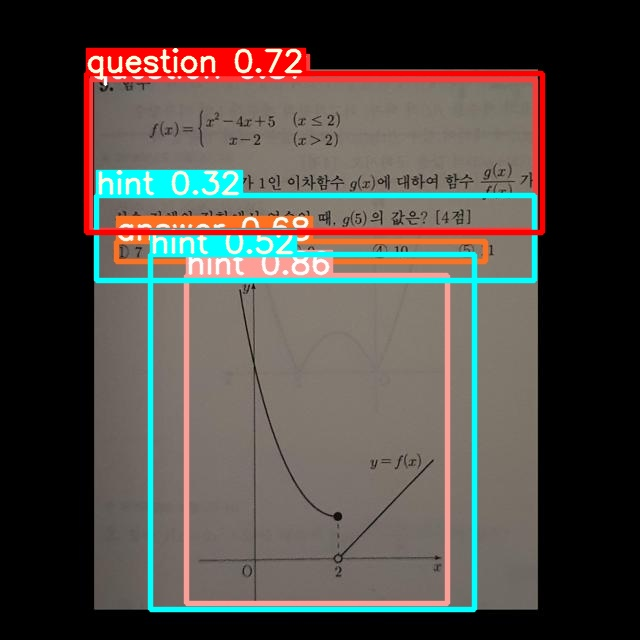

In [18]:
# OD_result, save_path = run_OD_model(input_path='input_example.jpg')  # 'runs/detect/exp2/수학2_1_극한과 연속_9번.jpg'
OD_result, save_path = run_OD_model(input_path='runs/detect/exp2/수학2_1_극한과 연속_9번.jpg')  # 'runs/detect/exp2/수학2_1_극한과 연속_9번.jpg'
pprint(OD_result)
Image_display(filename=save_path, width=600)

In [20]:
## TensorRT
# https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html#installing-pip
!pip install -U nvidia-tensorrt --index-url https://pypi.ngc.nvidia.com  # install
!python export.py --weights yolov5s.pt --include engine --imgsz 640 --device 0  # export
!python detect.py --weights yolov5s.engine --imgsz 640 --device 0  # inference

Looking in indexes: https://pypi.ngc.nvidia.com, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 774.4 MB 17 kB/s 
     |████████████████████████████████| 333.1 MB 40 kB/s 
     |████████████████████████████████| 849 kB 36.7 MB/s 
     |████████████████████████████████| 719.3 MB 18 kB/s 
  Created wheel for nvidia-cublas-cu11: filename=nvidia_cublas_cu11-2022.4.8-py3-none-any.whl size=15624 sha256=2fd18d0c1bf9235bc1b50a73591e2736bd2f02a3c3413a463824158023857c7e
  Stored in directory: /root/.cache/pip/wheels/e2/c3/94/1ffd5bac267cfdc2b222a4ec6915278ef18a028a916b9a5ac3
  Created wheel for nvidia-cuda-runtime-cu11: filename=nvidia_cuda_runtime_cu11-2022.4.25-py3-none-any.whl size=15696 sha256=a4af78a0ed68113e25378158a8c49db74919025e936c1f945d7edb03cda65423
  Stored in directory: /root/.cache/pip/wheels/df/fe/2b/e553db7867508b2268b14ac194e9ac5b3f51f21316c282c96c
  Created wheel for nvidia-cudnn-cu11: filename=nvidia_cudnn_cu11-2022.5.19-py3-none